In [10]:
import numpy as np
from pickle import load
from votekit.utils import mentions
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt
from src.viz import viz_order
from src.markov import gen_mentions_partition, random_partition, naive_proposal, tilted_run, short_burst
from src.scores import combined_score, cut_score, relative_size_score
from src.cleaning import Portland_clean
from src.clustering import create_graph_louvain_bm, louvain_partition_from_graph
from functools import partial


## Data Loading
The "src/cleaning.py" script give a generic function to clean Portland data.

In [2]:
with open('./data/Portland_D1.pkl', 'rb') as file:
    loaded = load(file)
boost = loaded['boost']
profile = Portland_clean(loaded['profile'])
print(profile.candidates)
candidates = loaded['candidates'] # note: these have to be listed in the same order as the boost matrix

712.0 ballots, or 1.6% of all ballots, were spoiled by overvotes or skips in D1.
279.0 ballots, or 0.6% of all ballots, were scrubbed by write ins in D1.
('Terrence Hayes', 'Doug Clove', 'Loretta Smith', 'Jamie Dunphy', 'Joe Furi', 'Thomas Shervey', 'Joe Allen', 'Michael (Mike) Sands', 'David Linn', 'Cayle Tern', 'Timur Ender', 'Candace Avalos', 'Noah Ernst', 'Deian Salazar', 'Peggy Sue Owens', 'Steph Routh')


## Visualization

A "partition" is a list of lists, representing a way of partitioning the candidates into slates.

The "src/viz.py" has a vizualization function, and "src/markov.py" has some initial partition generators.

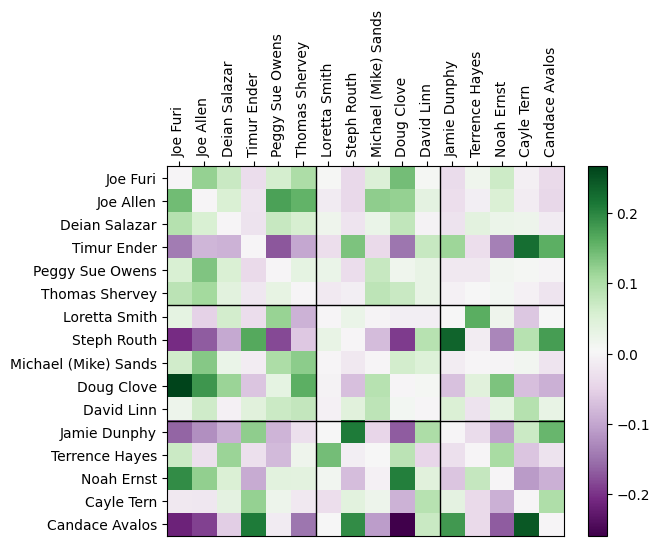

In [3]:
starting_partition = random_partition(candidates, 3)
mentions_partition = gen_mentions_partition(profile, candidates, 3)
viz_order(candidates, starting_partition, boost)

## Scores.

The "src/scores.py" contains several scoring functions for partitions, and linear combinations thereof.

As a general rule, these are scores we want to minimize. The cut_score is large when a partition separates candidates who are often adjacent in ballot rankings. The relative_size_score is high when the slates of the partition have unequal total mentions (this is maybe philosophically questionable).

Notice that these scores exist on different scales: the relative_size_score is orders of magnitude smaller than the cut_score. Do deal with this, we re-weigh them when we use them as part of a chain.

Below, we see that the mentions_partition has a better cut_score than the random partition.

In [4]:
print(cut_score(profile, starting_partition), relative_size_score(profile, starting_partition))
print(cut_score(profile, mentions_partition), relative_size_score(profile, mentions_partition))

191848.0 13.163066709412202
128566.0 17.83048011349329


## Chains.

The "src/markov.py" contains a proposal to get from one partition to the other, as well as a tilted run and a short burst chain, which can be run to optimize any score you pass to it.

To begin with, let's run a tilted run on our random starting partition.

In [5]:
best = tilted_run(profile, starting_partition, combined_score, iterations =1000)

Combined score of random partition: 323478.66709412204
Combined score of tilted run partition: 284461.1089719012


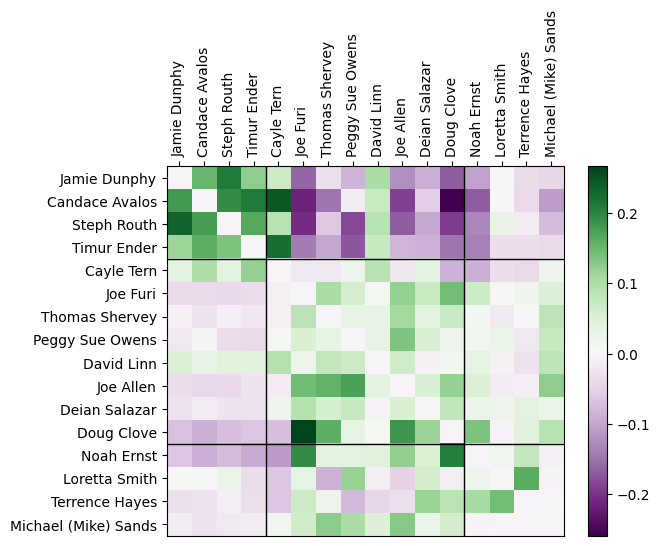

In [6]:
print(f"Combined score of random partition: {combined_score(profile, starting_partition)}")
print(f"Combined score of tilted run partition: {combined_score(profile, best)}")
viz_order(candidates, best, boost)

This looks decent, but you might begin to suspect that we would be better off using k=2 slates for this election, rather than 3. Let's try running another tilted run to do this.

In [7]:
starting_partition = random_partition(candidates, 2)
best = tilted_run(profile, starting_partition, combined_score, iterations =1000)

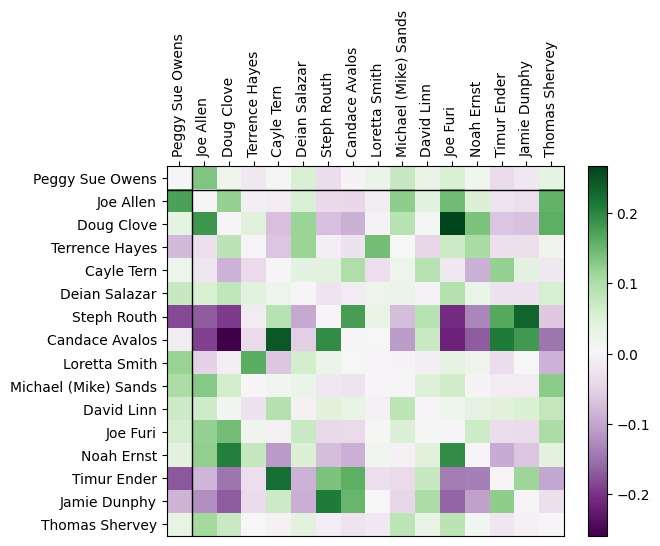

In [8]:
viz_order(candidates, best, boost)

Whoops! It looks as though our scoring functions are not weighted correctly to deal with k=2 slates; we need to give more weight to the relative_size_score.

The weight on this score is typically set at beta = 10000 when it is passed to combined_score; but we can change it by using a partial.

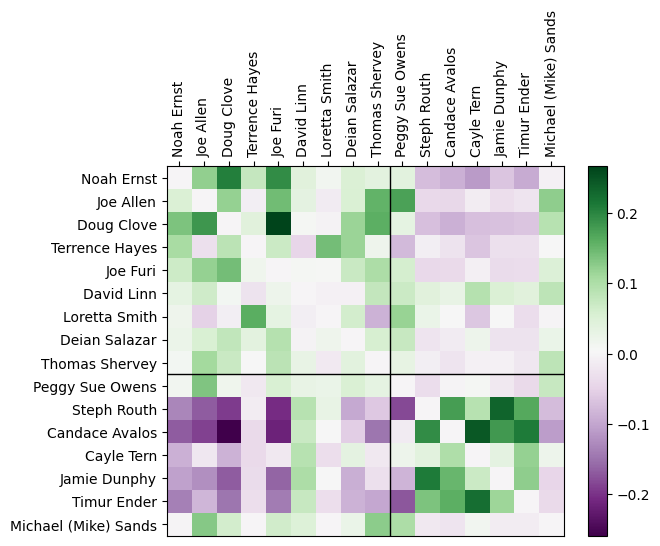

In [9]:
best2k=tilted_run(profile, starting_partition, partial(combined_score,alpha = 1, beta = 100000), iterations = 1000)
viz_order(candidates, best2k, boost)

You might still not be very happy with the above picture -- you could probably draw something better by swapping a couple positions. 

This is because the tilted run is getting stuck in local optima; it would take >=2 moves to find a better partition, and the chain is often rejecting the first of those moves because it hurts the relative_size score. 

To fix this, we can try running a short burst chain instead.

100%|██████████| 20/20 [01:25<00:00,  4.27s/it]


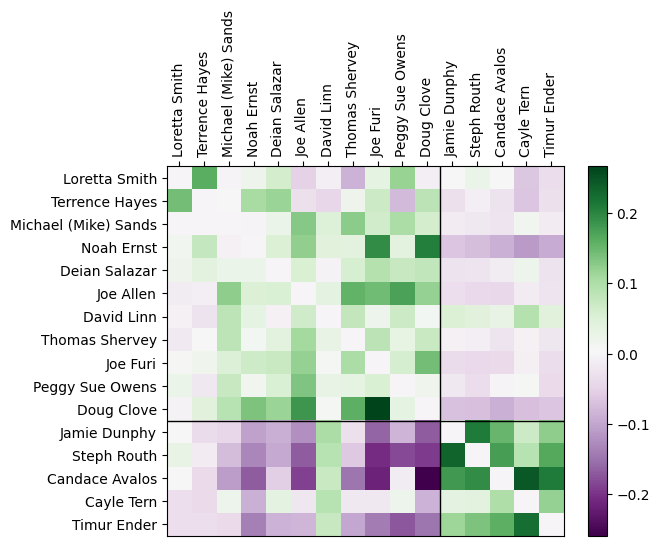

In [11]:
burst_best = short_burst(profile, starting_partition, partial(combined_score, alpha=1, beta=100000), burst_size=30, num_bursts=20)
viz_order(candidates, burst_best, boost)

Just for fun, let's compare the scores of our two chains' results:

In [12]:
score2k = partial(combined_score, alpha=1, beta=100000)
print(f"Combined score of tilted run partition: {score2k(profile, best2k)}")
print(f"Combined score of short burst partition: {score2k(profile, burst_best)}")

Combined score of tilted run partition: 391014.13898637285
Combined score of short burst partition: 384408.901824561


Weirdly, it looks like switching Linn over to the small block in the short_burst result does not give a better score -- despite looking smaller, the Avalos block contains more mentions than the Smith block, and even if Linn has positive boost with the Avalos block, he also has positive boost with the Smith block, and removing him from the latter would break more adjacencies.

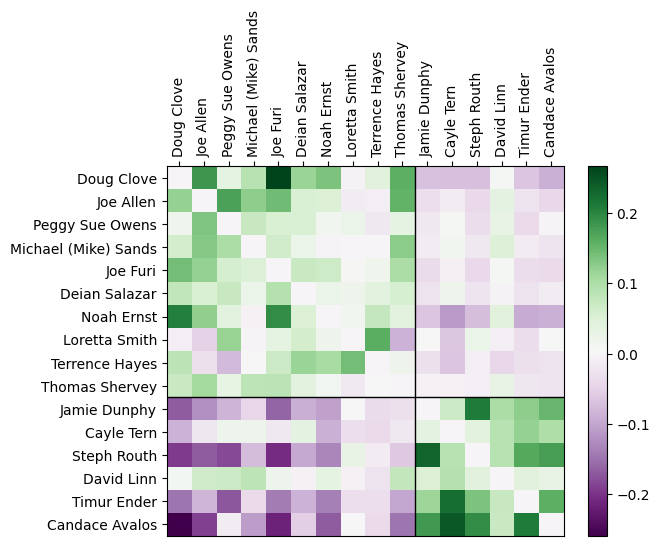

Cut score of the burst partition: 106592.0. Relative size score: 2.77816901824561.
Cut score of the flip_Linn run partition: 107732.0. Relative size score: 2.793941052321262.


In [13]:
flip_Linn = [['Doug Clove',
  'Joe Allen',
  'Peggy Sue Owens',
  'Michael (Mike) Sands',
  'Joe Furi',
  'Deian Salazar',
  'Noah Ernst',
  'Loretta Smith',
  'Terrence Hayes',
  'Thomas Shervey'],
 ['Jamie Dunphy',
  'Cayle Tern',
  'Steph Routh',
  'David Linn',
  'Timur Ender',
  'Candace Avalos']]
viz_order(candidates, flip_Linn, boost)
print(f"Cut score of the burst partition: {cut_score(profile, burst_best)}. Relative size score: {relative_size_score(profile, burst_best)}.")
print(f"Cut score of the flip_Linn run partition: {cut_score(profile, flip_Linn)}. Relative size score: {relative_size_score(profile, flip_Linn)}.")

# Louvain Method for Clustering

In [16]:
# create a graph from boost matrix
G = create_graph_louvain_bm(boost)
partition_louv = louvain_partition_from_graph(G, profile)
partition_louv

[['Loretta Smith',
  'Terrence Hayes',
  'Noah Ernst',
  'Doug Clove',
  'Deian Salazar',
  'Michael (Mike) Sands',
  'Joe Allen',
  'Joe Furi',
  'Peggy Sue Owens',
  'Thomas Shervey'],
 ['Candace Avalos',
  'Steph Routh',
  'Jamie Dunphy',
  'Timur Ender',
  'David Linn',
  'Cayle Tern']]

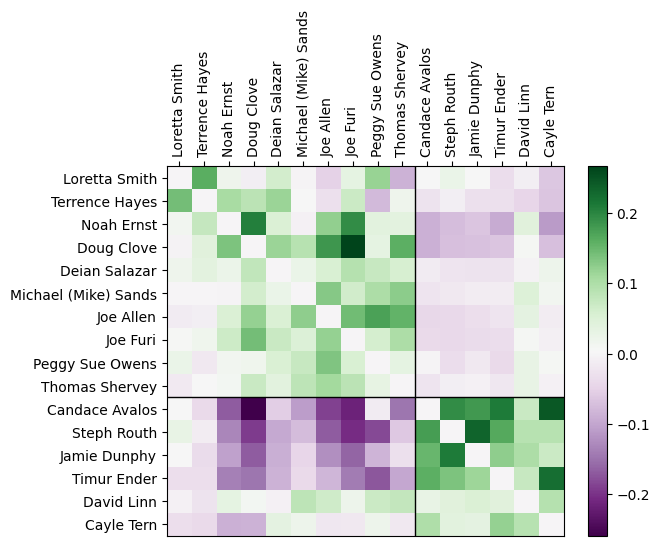

1.4281814051117754


np.float64(107732.0)

In [17]:
viz_order(candidates, partition_louv, boost)
first_second_score(profile, partition_louv)
cut_score(profile, partition_louv)